# Connect Notebook to Google Drive


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from google.colab import drive


In [6]:
drive.mount('/content/gdrive')
root_path = "/content/gdrive/MyDrive/Machine_Learning_NLP_Nora_Pauelsen_TU_Wien"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Feature Extraction: Get Word Embedding Vector with BERT 

Tutorial: https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [23]:
#pip install transformers

In [13]:
from transformers import BertTokenizer
import torch
import numpy as np
import pandas as pd

In [38]:
#Read in dataset
df_raw = pd.read_csv("/content/gdrive/MyDrive/Machine_Learning_NLP_Nora_Pauelsen_TU_Wien/data/raw/okcupid_profiles.csv")
df_raw.head(5)
df = df_raw[["sex", "essay0"]]


In [39]:
df_raw.shape

(59946, 31)

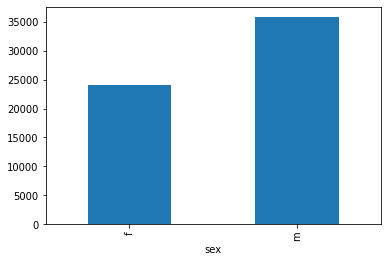

In [40]:
df.groupby(["sex"]).size().plot.bar()

In [41]:
df["female"] = ["1" if x == "f" else "0" for x in df["sex"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


BERT input Variables: 
* input_ids: id representation of each token (When decoded: "[CLS] text [SEP] [PAD]..."
* token_typ_ids: Binary mask that identifies in which sequence a token belongs, for a single sequence all token type ids are 0
* attention_mask: Binary mask that identifies whether a token is a real word or just padding




In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

labels = {'f': 1,          
          "m": 0}

In [34]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['sex']]
        self.texts = [tokenizer(essay0,
                               padding='max_length', max_length = 512, truncation=True, #512 is maximum length for tokens in 1 sequence
                                return_tensors="pt") for essay0 in df['essay0']]#.astype(str) #pt for pytorch

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [35]:
#split data into training, test and validation
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                         [int(.8 * len(df)), int(.9 * len(df))])

print(len(df_train), len(df_val), len(df_test))

47956 5995 5995


In [31]:
df_train["sex"].shape

(5084,)

In [32]:
df_train["essay0"].shape

(5084,)

In [36]:
#BUILD MODEL

from torch import nn
from transformers import BertModel

In [37]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1) #input Word embedding vector of 768, output: 1 (male/female)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

#TRAINING

from torch.optim import Adam
from tqdm import tqdm


def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCEWithLogitsLoss() #Changed loss function because binary: CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')


EPOCHS = 5
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyError: ignored

\# Predict sex with topic probability vector from BERTTopic

In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn
import matplotlib as plt

1. Load processed data

In [ ]:
#1. Target vector Y (sex)
df_topic_sex = pd.read_csv("C:/Users/norap/Documents/GitHub/Machine Learning NLP TU Wien/data/processed/df_topic_sex.csv")

#2. Feature Vector X (topic probabilities)
probs_topic_df = pd.read_csv("C:/Users/norap/Documents/GitHub/Machine Learning NLP TU Wien/data/processed/probs_topic_df.csv")

In [ ]:
df_topic_sex

,Profile_text,most_probable_topic,Sex,GenderDummy_F
0,currently working international agent freight ...,-1,m,0
1,dedicating everyday unbelievable badass.,-1,m,0
2,"make nerdy software musicians, artists, experi...",-1,m,0
3,reading things written old dead people,2,m,0
4,work work work work + play,100,m,0
...,...,...,...,...
52369,happiest times life came ran it-not ahead it. ...,-1,f,1
52370,"currently finishing school film production, em...",17,m,0
52371,"i'm civil engineer, enjoys helping citizens sa...",0,m,0
52372,"following dreams... ""you got dream... gotta pr...",114,m,0


2. Do a train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(probs_topic_df, df_topic_sex["GenderDummy_F"], test_size=0.33, random_state=42) #random state to make it reproducible

In [ ]:
y_train

2109     0
13196    0
44691    1
27049    0
2054     0
        ..
11284    1
44732    1
38158    0
860      0
15795    1
Name: GenderDummy_F, Length: 35090, dtype: int64

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,358,359,360,361,362,363,364,365,366,367
2109,0.001206,0.001502,0.001697,0.000855,0.002416,0.001533,0.001414,0.001180,0.001420,0.001109,...,0.003383,0.001264,0.001343,0.001907,0.001649,0.002387,0.001809,0.001366,0.001232,0.001509
13196,0.003484,0.154340,0.004782,0.001687,0.002139,0.005328,0.002260,0.001843,0.002701,0.001604,...,0.003132,0.001871,0.002225,0.003167,0.004520,0.003693,0.003384,0.003608,0.003403,0.002336
44691,0.000043,0.000037,0.000042,0.000024,0.000043,0.000033,0.000033,0.000038,0.000052,0.000031,...,0.000041,0.000041,0.000067,0.000101,0.000075,0.000078,0.000054,0.000047,0.000031,0.000075
27049,0.002351,0.001810,0.002068,0.001470,0.001427,0.002427,0.002133,0.001666,0.001606,0.001365,...,0.001934,0.001718,0.002072,0.001869,0.003574,0.002021,0.002159,0.001928,0.002908,0.001870
2054,0.002414,0.003622,0.004320,0.001426,0.001689,0.005036,0.001918,0.001586,0.002067,0.001336,...,0.002494,0.001607,0.002168,0.002195,0.006054,0.002903,0.002494,0.002164,0.003888,0.002087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.000352,0.000379,0.000403,0.000271,0.000570,0.000397,0.000388,0.000348,0.000367,0.000337,...,0.000625,0.000368,0.000361,0.000453,0.000395,0.000488,0.000428,0.000377,0.000346,0.000409
44732,0.002725,0.001856,0.001737,0.001121,0.001986,0.001712,0.002238,0.001472,0.001639,0.001304,...,0.003212,0.001592,0.001814,0.003720,0.002595,0.002875,0.004398,0.003122,0.001567,0.002133
38158,0.000555,0.000745,0.000840,0.000368,0.001270,0.000709,0.000633,0.000521,0.000693,0.000483,...,0.002000,0.000561,0.000614,0.001045,0.000809,0.001394,0.000929,0.000660,0.000544,0.000750
860,0.003198,0.043703,0.003990,0.001507,0.001753,0.004981,0.001999,0.001599,0.002255,0.001385,...,0.002540,0.001616,0.001896,0.002542,0.003810,0.002917,0.002835,0.003082,0.003238,0.001965


### Convert X and y labels to numpy

In [ ]:
X_train = X_train.to_numpy()

In [ ]:
y_train = y_train.to_numpy()

In [ ]:
X_test = X_test.to_numpy()
X_test = torch.from_numpy(X_test)

In [ ]:
y_test = y_test.to_numpy()
y_test = torch.from_numpy(y_test)

### Make X and y labels tensors

In [ ]:
X_train = torch.from_numpy(X_train)

In [ ]:
X_train.shape

torch.Size([35090, 368])

In [ ]:
y_train = torch.from_numpy(y_train)

In [ ]:
type(y_train)

torch.Tensor

In [ ]:
y_train.shape

torch.Size([35090])

In [ ]:
X_train.shape, y_train.shape

(torch.Size([35090, 368]), torch.Size([35090]))

In [ ]:
X_train[:5], y_train[:5]

(tensor([[1.2063e-03, 1.5015e-03, 1.6973e-03,  ..., 1.3657e-03, 1.2316e-03,
          1.5085e-03],
         [3.4836e-03, 1.5434e-01, 4.7818e-03,  ..., 3.6082e-03, 3.4034e-03,
          2.3365e-03],
         [4.2651e-05, 3.6638e-05, 4.2236e-05,  ..., 4.7134e-05, 3.0976e-05,
          7.4609e-05],
         [2.3508e-03, 1.8099e-03, 2.0679e-03,  ..., 1.9282e-03, 2.9085e-03,
          1.8704e-03],
         [2.4140e-03, 3.6219e-03, 4.3196e-03,  ..., 2.1642e-03, 3.8883e-03,
          2.0872e-03]], dtype=torch.float64),
 tensor([0, 0, 1, 0, 0]))

In [ ]:
import torch
import torch.nn as nn

## Pytorch Workflow

## 2. Create a model (input, output size, forward pass)

In [ ]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# 1. Construct a model class that subclasses nn.Module
class NeuralNetwork_binary(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=368, out_features=500) # takes in 370 features (X), produces 500 features TODO: How many output features here (meaning how many hidden layers?)
        self.layer_2 = nn.Linear(in_features=500, out_features=500)
        self.layer_3 = nn.Linear(in_features=500, out_features=1) # takes in 500 features, produces 1 feature (y)
        self.relu = nn.ReLU() # <- add in ReLU activation function

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

In [ ]:
# 4. Create an instance of the model and send it to target device
model_0 = NeuralNetwork_binary().to(device)
model_0

NeuralNetwork_binary(
  (layer_1): Linear(in_features=368, out_features=500, bias=True)
  (layer_2): Linear(in_features=500, out_features=500, bias=True)
  (layer_3): Linear(in_features=500, out_features=1, bias=True)
  (relu): ReLU()
)

2.) Construct loss and optimizer
Iterate this:
3.) Training Loop:
    - forward pass: compute prediction
    - backward pass: gradients
    - Update weights

## Define a Loss Function and Optimizer
Because we have a binary classification problem: Use binary cross entropy as loss function
We use Stochastic Gradient Descent as optimizer

In [ ]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

## Define a function for calculating accuracy as evaluation metric

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## Training the model
1. Forward Pass: Model goes through all of the training data once
2. Calculate the Loss
3. Set optimizer gradients to zero
4. Perform backpropagation on the Loss
5. Update the parameters with gradient descent

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device TODO: What does that mean?
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train.float()).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits,
                   y_train.float())
    acc = accuracy_fn(y_true=y_train.float(),
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test.float()).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test.float())
        test_acc = accuracy_fn(y_true=y_test.float(),
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69068, Accuracy: 60.21% | Test loss: 0.68963, Test acc: 59.63%
Epoch: 10 | Loss: 0.68130, Accuracy: 60.21% | Test loss: 0.68153, Test acc: 59.63%
Epoch: 20 | Loss: 0.67663, Accuracy: 60.21% | Test loss: 0.67765, Test acc: 59.63%
Epoch: 30 | Loss: 0.67434, Accuracy: 60.21% | Test loss: 0.67583, Test acc: 59.63%
Epoch: 40 | Loss: 0.67321, Accuracy: 60.21% | Test loss: 0.67502, Test acc: 59.63%
Epoch: 50 | Loss: 0.67266, Accuracy: 60.21% | Test loss: 0.67467, Test acc: 59.63%
Epoch: 60 | Loss: 0.67240, Accuracy: 60.21% | Test loss: 0.67453, Test acc: 59.63%
Epoch: 70 | Loss: 0.67227, Accuracy: 60.21% | Test loss: 0.67449, Test acc: 59.63%
Epoch: 80 | Loss: 0.67221, Accuracy: 60.21% | Test loss: 0.67449, Test acc: 59.63%
Epoch: 90 | Loss: 0.67218, Accuracy: 60.21% | Test loss: 0.67450, Test acc: 59.63%
